<a href="https://colab.research.google.com/github/rboghe/cened/blob/master/cened_2_0_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [55]:
import os
import urllib.request
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from lightgbm import LGBMRegressor, plot_importance
import seaborn as sns

# Silence pandas setting with copy warning
pd.options.mode.chained_assignment = None

# Set Seaborn style
sns.set_theme(style="white")

# Load data

In [56]:
# Cened 2.0
url = 'https://www.dati.lombardia.it/api/views/bbky-sde5/rows.csv?accessType=DOWNLOAD'

if os.path.isdir('/tmp'):
    if os.path.isfile('/tmp/cened20.csv'):
      pass
    else:
      urllib.request.urlretrieve(url, '/tmp/cened20.csv')
else:
  os.mkdir('/tmp')
  urllib.request.urlretrieve(url, '/tmp/cened20.csv')

In [57]:
# DDH
url = 'https://raw.githubusercontent.com/rboghe/cened/master/degreedays.txt'

urllib.request.urlretrieve(url, '/tmp/ddh.csv')

ddh = pd.read_csv('/tmp/ddh.csv', usecols = ['comune','dd'])

In [58]:
cols = ['INTERO_EDIFICIO', 'RIQUALIFICAZIONE_ENERGETICA', 'ZONA_CLIMATICA',
           'ANNO_COSTRUZIONE','SUPERF_UTILE_RISCALDATA', 'SUPERF_UTILE_RAFFRESCATA',
           'VOLUME_LORDO_RISCALDATO', 'VOLUME_LORDO_RAFFRESCATO', 'CLASSE_ENERGETICA', 
           'SUPERFICIE_DISPERDENTE', 'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE', 
           'CLASSIFICAZIONE_DPR', 'COMUNE', 'EP_H_ND','EP_GL_NREN','EP_GL_REN', 
           'NUMERO_UNITA_IMMOBILIARI', 'RISTRUTTURAZIONE_IMPORTANTE', 'Y']
  
cened_new = pd.read_csv('/tmp/cened20.csv', usecols = cols)

In [59]:
len(cened_new) #942,086 

942086

# Preprocessing

In [60]:
# Fillna
for col in ['EP_GL_NREN', 'EP_GL_REN']:
    cened_new[col].fillna(0, inplace=True)

# Drop buildings with NaN values
cened_new.dropna(inplace = True)

# Only entire buildings
# cened_new = cened_new[cened_new['INTERO_EDIFICIO'] == True]

# Drop renovations
#cened_new = cened_new[cened_new['RISTRUTTURAZIONE_IMPORTANTE'] == False]
#cened_new = cened_new[cened_new['RIQUALIFICAZIONE_ENERGETICA'] == False]

# We'll use residential buildings only
cened_new['CLASSIFICAZIONE_DPR'] = cened_new['CLASSIFICAZIONE_DPR'].str.replace(r'E.1 (1)', 'E.1(1)')
cened_new = cened_new[cened_new['CLASSIFICAZIONE_DPR'] == 'E.1(1)']

# Add ddh
cened_new['COMUNE'] = cened_new['COMUNE'].str.lower()
ddh['comune'] = ddh['comune'].str.lower()
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"`",  "'")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"o`",  "o'")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"baranzate",  "bollate")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"bovisio masciago",  "bovisio-masciago")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"cornate d`adda",  "cornate d'adda")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"cortenuova",  "cortenova")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"sant'omobono terme",  "sant'omobono imagna")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"borgo virgilio",  "virgilio")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r" - ",  "-")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"cassina de pecchi",  "cassina de' pecchi")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"cerano intelvi",  "cerano d'intelvi")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"colverde",  "drezzo")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"cornale e bastida",  "cornale")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"corteolona e genzone",  "corteolona")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"costa serina",  "costa di serina")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"gabbioneta binanuova",  "gabbioneta-binanuova")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"gadesco pieve delmona",  "gadesco-pieve delmona")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"gerre de'caprioli",  "gerre de' caprioli")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"gravedona ed uniti",  "grandola ed uniti")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"la valletta brianza",  "perego")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"lonato del garda",  "lonato")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"maccagno con pino e veddasca",  "maccagno")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"ramponio vernia",  "ramponio verna")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"sermide e felonica",  "sermide")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"toscolano maderno",  "toscolano-maderno")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"tremezzina",  "tremezzo")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"val brembilla",  "brembilla")
cened_new['COMUNE'] = cened_new['COMUNE'].str.replace(r"verderio",  "verderio inferiore")

ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"è",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"é",  "e'")
ddh['comune'] = ddh['comune'].str.replace(r"ò",  "o'")
ddh['comune'] = ddh['comune'].str.replace(r"ù",  "u'")

cened_new = cened_new.merge(ddh, left_on='COMUNE', right_on='comune', how='left')

# Riqualificazione
cened_new['RIQUALIFICAZIONE_ENERGETICA'] = cened_new['RIQUALIFICAZIONE_ENERGETICA'].astype("category").cat.codes

# Ristrutturazione
cened_new['RISTRUTTURAZIONE_IMPORTANTE'] = cened_new['RISTRUTTURAZIONE_IMPORTANTE'].astype("category").cat.codes

# Climatizzazione
#cened_new['CLIMATIZZAZIONE_INVERNALE'] = cened_new['CLIMATIZZAZIONE_INVERNALE'].astype("category").cat.codes

# Correct floats
for col in ['SUPERF_UTILE_RISCALDATA',
           'SUPERF_UTILE_RAFFRESCATA','VOLUME_LORDO_RISCALDATO','VOLUME_LORDO_RAFFRESCATO','SUPERFICIE_DISPERDENTE',
           'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE','EP_H_ND','EP_GL_NREN','EP_GL_REN']:
    cened_new[col] = cened_new[col].astype(str)
    cened_new[col] = cened_new[col].str.replace(r',', '')
    cened_new[col] = cened_new[col].astype("float")

In [61]:
#EPG
cened_new['EPG'] = cened_new['EP_GL_NREN'] + cened_new['EP_GL_REN']

In [62]:
# Full DB of residential buildings without missing data
print(len(cened_new))

439630


# Feature engineering

In [63]:
# Mean height
cened_new['ALTEZZA_MEDIA'] = cened_new['VOLUME_LORDO_RISCALDATO']/cened_new['SUPERF_UTILE_RISCALDATA']

# Period
cened_new.ANNO_COSTRUZIONE = cened_new.ANNO_COSTRUZIONE.astype(str)
cened_new.ANNO_COSTRUZIONE = cened_new.ANNO_COSTRUZIONE.map(lambda x:x[-4:])
cened_new.ANNO_COSTRUZIONE = cened_new.ANNO_COSTRUZIONE.astype(int)

cened_new['PERIODO'] = pd.cut(cened_new.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000],
     labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', '1993-2006','After 2006']).cat.codes

# East facing surface
cened_new['A_SOL_EST'] = cened_new['A_SOL_EST_A_SUP_UTILE']*cened_new['SUPERF_UTILE_RISCALDATA']

# Filters

In [64]:
cened_new = cened_new[cened_new['EP_H_ND'] > 5]
cened_new = cened_new[cened_new['EP_H_ND'] < 1000]

In [65]:
cened_new = cened_new[cened_new['SUPERF_UTILE_RISCALDATA'] >= 50]

In [66]:
cened_new = cened_new[cened_new['VOLUME_LORDO_RISCALDATO'] >= 150]

In [67]:
cened_new = cened_new[cened_new['ALTEZZA_MEDIA'] > 2.4]

In [68]:
cened_new = cened_new[cened_new['Y_IE'] <= 6]
cened_new = cened_new[cened_new['Y_IE'] >= 0.01] #0.03

In [69]:
cened_new = cened_new[cened_new['A_SOL_EST_A_SUP_UTILE'] <= 0.5]
cened_new = cened_new[cened_new['A_SOL_EST_A_SUP_UTILE'] > 0]

In [70]:
len(cened_new)

299425

# Data analysis

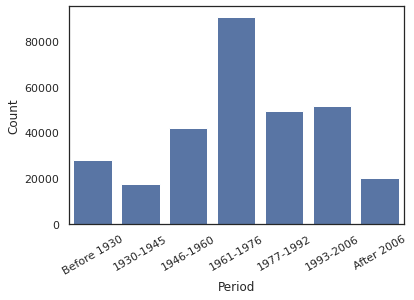

In [71]:
# Period
fig = plt.figure(figsize = (6,4))
cplot = sns.countplot(x = pd.cut(cened_new.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'Period')
plt.xticks(rotation=30)
plt.show()

# Shuffle

In [72]:
cened = cened_new.sample(frac=1).reset_index(drop=True)

# Reserve a test set

In [73]:
msk = np.random.rand(len(cened)) < 0.8
train = cened[msk]
test = cened[~msk]

In [74]:
print(len(train))

239660


In [75]:
print(len(test)) # 6646

59765


# Define MAPE

In [76]:
def neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return -np.abs((y_true - y_pred)/y_true).mean()

In [77]:
def modified_neg_mape(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  errors = np.abs((y_true - y_pred)/y_true)
  index = np.argwhere(errors > 1)
  mod_errors = np.delete(errors, index)
  return -mod_errors.mean()

In [78]:
neg_mape_scorer = make_scorer(neg_mape, greater_is_better=True)

In [79]:
modified_neg_mape_scorer = make_scorer(modified_neg_mape, greater_is_better=True)

# Random search

In [80]:
mlcol = ['SUPERF_UTILE_RISCALDATA',
           'VOLUME_LORDO_RISCALDATO',
           'SUPERFICIE_DISPERDENTE', 'dd','PERIODO',
           'RAPPORTO_SV','A_SOL_EST_A_SUP_UTILE','Y_IE',
           'ALTEZZA_MEDIA', 'A_SOL_EST', 'NUMERO_UNITA_IMMOBILIARI']

In [81]:
cat_feats = ['PERIODO']

In [102]:
param_dist = {'feature_fraction': np.linspace(0.4, 1, num=7),
              'num_leaf' : list(range(20,40)),
             'max_depth' : [-1],
             'max_bin' : [100, 200, 300, 500, 750, 1000, 2000],
             'bagging_fraction' : np.linspace(0.4, 1, num=14),
             'bagging_freq' : list(range(1,10)),
             'lambda_l1' : stats.uniform(0, 0.6),
             'lambda_l2' : stats.uniform(0, 0.6)}

lgbm = LGBMRegressor(n_estimators = 200, silent = True, verbose = 0, is_training_metric = True, n_jobs = 1, 
                     eval_metric  = 'mape')

n_iter_search = 100

random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=n_iter_search, 
                                   scoring={'MAPE' : neg_mape_scorer, 'MAPE <100%' : modified_neg_mape_scorer, 'R2' : 'r2'} , cv = 5, n_jobs = 6, verbose = 2, refit = 'MAPE')

random_search.fit(cened[mlcol], cened['EP_H_ND'], categorical_feature = cat_feats)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 353 tasks      | elapsed: 26.2min
[Parallel(n_jobs=6)]: Done 500 out of 500 | elapsed: 36.3min finished
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['PERIODO']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           eval_metric='mape',
                                           importance_type='split',
                                           is_training_metric=True,
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=200,
                                           n_jobs=1, num_leaves=31,
                                           objective=None, random_sta...
                                        'lambda_l2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4a48c2ab38>,
            

# Print results

In [103]:
print(random_search.best_params_)

{'bagging_fraction': 0.9076923076923077, 'bagging_freq': 8, 'feature_fraction': 0.8999999999999999, 'lambda_l1': 0.03742387447520421, 'lambda_l2': 0.4706179249474256, 'max_bin': 2000, 'max_depth': -1, 'num_leaf': 39}


In [104]:
print(random_search.best_score_)

-0.3522126247793232


In [105]:
# Create a results df
cv_df = pd.DataFrame(random_search.cv_results_)
cv_df = cv_df.sort_values(by = ['rank_test_MAPE']).reset_index()

# Filter columns
res_cols = [col for col in cv_df if col.startswith('split')]

# Select best iter
best_res = cv_df.loc[0]

# Print results for each fold
print(best_res[res_cols]) # around 23

split0_test_MAPE         -0.353308
split1_test_MAPE         -0.351425
split2_test_MAPE         -0.352885
split3_test_MAPE         -0.351518
split4_test_MAPE         -0.351927
split0_test_MAPE <100%   -0.243483
split1_test_MAPE <100%   -0.245873
split2_test_MAPE <100%   -0.243127
split3_test_MAPE <100%   -0.244553
split4_test_MAPE <100%   -0.243839
split0_test_R2            0.641427
split1_test_R2            0.636743
split2_test_R2            0.630386
split3_test_R2             0.63154
split4_test_R2            0.635593
Name: 0, dtype: object


In [130]:
# Best R2
print(best_res.mean_test_R2)

0.6351378592066386


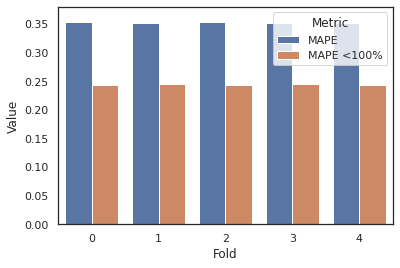

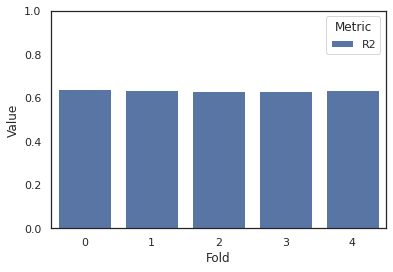

In [106]:
df = pd.DataFrame(best_res[res_cols])
df = df.rename(columns = {0:'Value'})
df['Fold'] = df.index.str[5:6]
df['Metric'] = df.index.str[12:]
df['Value'] = np.where(df['Metric'] == 'R2', df['Value'], df['Value'] * -1)
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] != 'R2'])
ax.set(ylim = (0, 0.38))
plt.show()
ax = sns.barplot(x='Fold', y="Value", hue="Metric", data = df[df['Metric'] == 'R2'])
ax.set(ylim = (0, 1))
plt.show()

# Train the final model

In [131]:
light = LGBMRegressor(n_estimators = 1000, silent = False, verbose = 2, is_training_metric = True, n_jobs = 6)
light.set_params(**random_search.best_params_)

LGBMRegressor(bagging_fraction=0.9076923076923077, bagging_freq=8,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.8999999999999999, importance_type='split',
              is_training_metric=True, lambda_l1=0.03742387447520421,
              lambda_l2=0.4706179249474256, learning_rate=0.1, max_bin=2000,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=6, num_leaf=39,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

In [132]:
light.fit(train[mlcol], train['EP_H_ND'])

LGBMRegressor(bagging_fraction=0.9076923076923077, bagging_freq=8,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.8999999999999999, importance_type='split',
              is_training_metric=True, lambda_l1=0.03742387447520421,
              lambda_l2=0.4706179249474256, learning_rate=0.1, max_bin=2000,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=1000, n_jobs=6, num_leaf=39,
              num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=False, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbose=2)

# Test the model

In [133]:
y_pred = light.predict(test[mlcol]).clip(0)

In [134]:
results_df = pd.DataFrame({'Predicted' : y_pred, 'True' : test['EP_H_ND']})
results_df['error'] = np.abs((results_df['True'] - results_df['Predicted'])/results_df['True'])*100

In [135]:
# MAPE
results_df[results_df.error <= 1000].error.mean()

34.43952645634484

In [136]:
# Max % error
results_df['error'].max()

1790.8491211716068

In [137]:
# Row with the highest % error
results_df.iloc[results_df['error'].argmax()]

Predicted     213.098696
True           11.270000
error        1790.849121
Name: 151855, dtype: float64

In [138]:
# MAPE without >100%
results_df[results_df.error <= 100].error.mean()

24.185214203285582

In [139]:
# R2 
print(r2_score(test['EP_H_ND'], y_pred))

0.6385957354075156


In [140]:
# R2 without >100%
print(r2_score(results_df[results_df.error <= 100]['True'], results_df[results_df.error <= 100].Predicted))

0.6729274195665467


In [141]:
results_df

,Predicted,True,error
1,55.669123,38.21,45.692549
4,142.155524,177.04,19.704291
9,118.426656,79.35,49.245944
13,100.699638,61.25,64.407572
14,85.005472,90.39,5.956995
...,...,...,...
299397,87.567093,99.66,12.134163
299400,85.656942,136.22,37.118674
299404,69.640398,31.47,121.291381
299406,43.788770,52.90,17.223497


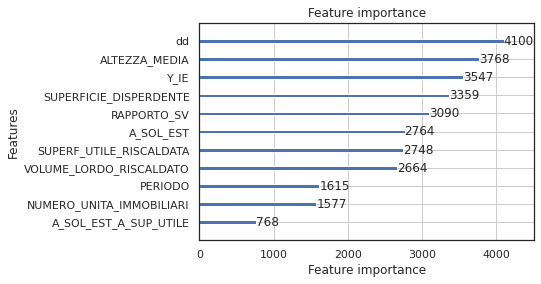

In [142]:
plot_importance(light)

# Error analysis

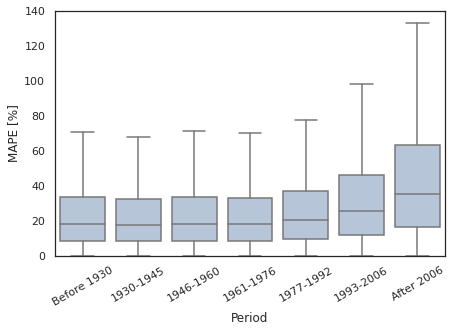

In [157]:
# Period
bins = pd.cut(test.ANNO_COSTRUZIONE, bins=[0,1930,1945,1960,1976,1992,2006,3000], 
       labels=['Before 1930','1930-1945','1946-1960','1961-1976', '1977-1992', 
               '1993-2006','After 2006'])

fig = plt.figure(figsize = (7, 4.5))
box = sns.boxplot(y = results_df.error, x = bins, 
                  color='lightsteelblue', orient = 'v', 
                  showfliers = False)

box.set(ylim = (0, 140), ylabel = 'MAPE [%]', xlabel = 'Period')
plt.xticks(rotation=30)
plt.show()

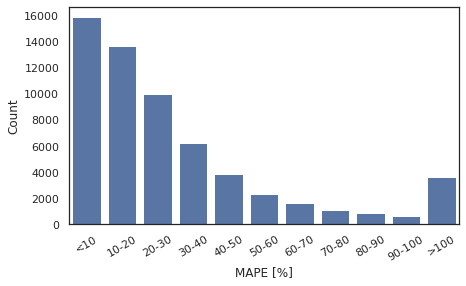

In [148]:
# Error
fig = plt.figure(figsize = (7,4))
cplot = sns.countplot(x = pd.cut(results_df.error, bins=[0,10,20,30,40,50,60,70,80,90,100,10000],
                                 labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100']), color = 'b')
cplot.set(ylabel = 'Count', xlabel = 'MAPE [%]')
plt.xticks(rotation=30)
plt.show()

In [158]:
pd.cut(results_df.error, bins=[0,10,20,30,40,50,60,70,80,90,100,10000], labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '>100']).value_counts()

<10       15905
10-20     13677
20-30      9970
30-40      6215
40-50      3867
>100       3621
50-60      2322
60-70      1633
70-80      1112
80-90       818
90-100      625
Name: error, dtype: int64

In [155]:
pd.cut(results_df.error, bins=[0,20,10000], labels = ['<20', '>20']).value_counts()

>20    30183
<20    29582
Name: error, dtype: int64

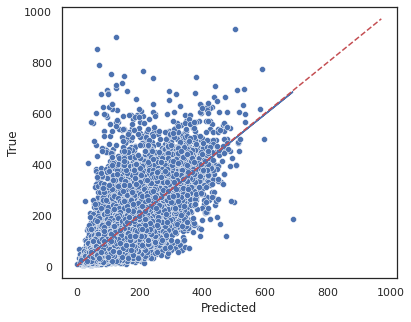

In [145]:
# Scatterplot
fig = plt.figure(figsize = (6,5))
scatter = sns.scatterplot(data=results_df, x="Predicted", y="True")
#scatter.set(ylabel = 'True', xlabel = 'Predicted',
#            xlim=(-30, 1000), ylim=(-30, 1000))
m, b = np.polyfit(results_df['Predicted'], results_df['True'], 1)
plt.plot(results_df['Predicted'].values, m*results_df['Predicted'] + b)
plt.plot([0, 970], [0,970], c = 'r', linestyle='--')
plt.show()